# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

# Sentiment Analysis on JAMB Scores in Nigeria Using Twitter Data

## Import Required Libraries

In [103]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.chrome.options import Options
import time
from datetime import datetime
import logging

from textblob import TextBlob
import string
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
from collections import Counter
import pandas as pd 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import nltk
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
from nltk.stem.porter import *

from sklearn.model_selection import train_test_split

from wordcloud import WordCloud


from nltk.corpus import stopwords

import warnings

warnings.filterwarnings("ignore")

pd.options.plotting.backend = "plotly"
nltk.download("stopwords")
%matplotlib inline


[nltk_data] Error loading stopwords: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>


# Configure Logging
## This is for work output instead of using print function everytime

In [2]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# JAMBTwitterScraper Class - Initialization
## The class used for scraping data from twitter 

In [8]:
class JAMBTwitterScraper:
    def __init__(self, use_existing_chrome=True, debug_port=9222):
        """Initialize the Twitter scraper for JAMB-related tweets"""
        self.use_existing_chrome = use_existing_chrome
        self.debug_port = debug_port
        self.setup_driver()
        self.tweets_data = []

    def setup_driver(self):
        """Set up Chrome driver - either new instance or connect to existing"""
        chrome_options = Options()

        if self.use_existing_chrome:
            # Connect to existing Chrome instance
            chrome_options.add_experimental_option("debuggerAddress", f"127.0.0.1:{self.debug_port}")
            logger.info(f"Attempting to connect to existing Chrome on port {self.debug_port}")
            logger.info(
                "Make sure Chrome is running with: chrome.exe --remote-debugging-port=9222 --user-data-dir=remote-profile")
        else:
            # Create new Chrome instance
            chrome_options.add_argument("--no-sandbox")
            chrome_options.add_argument("--disable-dev-shm-usage")
            chrome_options.add_argument("--disable-gpu")
            chrome_options.add_argument("--window-size=1920,1080")
            chrome_options.add_argument("--user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36")

        try:
            self.driver = webdriver.Chrome(options=chrome_options)
            self.wait = WebDriverWait(self.driver, 10)

            if self.use_existing_chrome:
                logger.info("Successfully connected to existing Chrome browser")
            else:
                logger.info("New Chrome driver initialized successfully")

        except Exception as e:
            if self.use_existing_chrome:
                logger.error(f"Failed to connect to existing Chrome. Error: {e}")
                logger.error("Please make sure Chrome is running with remote debugging enabled")
                logger.error(
                    "Run this command first: chrome.exe --remote-debugging-port=9222 --user-data-dir=remote-profile")
            else:
                logger.error(f"Failed to initialize Chrome driver: {e}")
            raise

    def search_jamb_tweets(self, search_terms=None, max_tweets=100):
        """
        Search for JAMB-related tweets on Twitter
        Note: This requires being logged into Twitter
        """
        if search_terms is None:
            search_terms = [
                'jamb',  # %23
                'utme',
                # "JAMB scores",
                # "JAMB results",
                # "JAMB 2024",
                # "UTME scores",
                # "JAMB cut off",
                # "JAMB admission"
            ]

        all_tweets = []

        for term in search_terms:
            logger.info(f"Searching for tweets with term: {term}")
            tweets = self.scrape_twitter_search(term, max_tweets)  # // len(search_terms)
            all_tweets.extend(tweets)
            time.sleep(2)  # Rate limiting

        self.tweets_data = all_tweets
        return all_tweets

    def scrape_twitter_search(self, search_term, max_tweets=50):
        """Scrape tweets for a specific search term"""
        tweets = []

        try:
            # Navigate to Twitter search
            search_url = f"https://x.com/search?q={search_term.replace(' ', '%20')}&src=typed_query" # &f=live
            self.driver.get(search_url)
            time.sleep(3)

            # Scroll and collect tweets
            last_height = self.driver.execute_script("return document.body.scrollHeight")
            tweet_count = 0

            while tweet_count < max_tweets:
                # Find tweet elements
                tweet_elements = self.driver.find_elements(By.CSS_SELECTOR, '[data-testid="tweet"]')

                for tweet_element in tweet_elements:
                    if tweet_count >= max_tweets:
                        break

                    try:
                        tweet_data = self.extract_tweet_data(tweet_element)
                        if tweet_data and self.is_jamb_related(tweet_data['text']):
                            tweets.append(tweet_data)
                            tweet_count += 1
                    except Exception as e:
                        logger.warning(f"Error extracting tweet data: {e}")
                        continue

                # Scroll down
                self.driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
                time.sleep(2)

                # Check if we've reached the bottom
                new_height = self.driver.execute_script("return document.body.scrollHeight")
                if new_height == last_height:
                    break
                last_height = new_height

        except Exception as e:
            logger.error(f"Error scraping tweets for term '{search_term}': {e}")

        return tweets

    def extract_tweet_data(self, tweet_element):
        """Extract relevant data from a tweet element"""
        try:
            # Extract tweet text
            text_element = tweet_element.find_element(By.CSS_SELECTOR, '[data-testid="tweetText"]')
            text = text_element.text

            # Extract username
            try:
                username_element = tweet_element.find_element(By.CSS_SELECTOR, '[data-testid="User-Name"] a')
                username = username_element.get_attribute('href').split('/')[-1]
            except:
                username = "unknown"

            # Extract timestamp (this might need adjustment based on Twitter's current structure)
            try:
                time_element = tweet_element.find_element(By.TAG_NAME, 'time')
                timestamp = time_element.get_attribute('datetime')
            except:
                timestamp = datetime.now().isoformat()

            # Extract engagement metrics
            try:
                likes_element = tweet_element.find_element(By.CSS_SELECTOR, '[data-testid="like"] span')
                likes = self.parse_engagement_count(likes_element.text)
            except:
                likes = 0

            try:
                retweets_element = tweet_element.find_element(By.CSS_SELECTOR, '[data-testid="retweet"] span')
                retweets = self.parse_engagement_count(retweets_element.text)
            except:
                retweets = 0

            return {
                'text': text,
                'username': username,
                'timestamp': timestamp,
                'likes': likes,
                'retweets': retweets,
            }

        except Exception as e:
            logger.warning(f"Error extracting tweet data: {e}")
            return None

    def parse_engagement_count(self, count_text):
        """Parse engagement count (handles K, M suffixes)"""
        if not count_text or count_text == '':
            return 0

        count_text = count_text.lower()
        if 'k' in count_text:
            return int(float(count_text.replace('k', '')) * 1000)
        elif 'm' in count_text:
            return int(float(count_text.replace('m', '')) * 1000000)
        else:
            try:
                return int(count_text)
            except:
                return 0

    def is_jamb_related(self, text):
        """Check if tweet text is related to JAMB"""
        jamb_keywords = [
            'jamb', 'utme', 'joint admissions', 'matriculation',
            'jamb score', 'jamb result', 'cut off', 'admission',
            'university', 'polytechnic', 'college of education'
        ]

        text_lower = text.lower()
        return any(keyword in text_lower for keyword in jamb_keywords)

    def save_tweets_to_csv(self, filename='jamb_tweets.csv'):
        """Save collected tweets to CSV file"""
        if not self.tweets_data:
            logger.warning("No tweets data to save")
            return

        df = pd.DataFrame(self.tweets_data)
        df.to_csv(filename, index=False)
        logger.info(f"Saved {len(self.tweets_data)} tweets to {filename}")

    def close(self):
        """Close the browser driver"""
        if hasattr(self, 'driver'):
            self.driver.quit()


In [5]:
def setup_chrome_for_automation():
    """
    Instructions and helper function for setting up Chrome for automation
    """
    print("=== SETUP INSTRUCTIONS FOR USING EXISTING CHROME ===")
    print("1. Close all Chrome windows")
    print("2. Open Command Prompt (Windows) or Terminal (Mac/Linux)")
    print("3. Run one of these commands:")
    print("\n   Windows:")
    print(
        '   "C:\\Program Files\\Google\\Chrome\\Application\\chrome.exe" --remote-debugging-port=9222 --user-data-dir=C:\\temp\\chrome-automation')
    print("\n   Mac:")
    print(
        '   /Applications/Google\\ Chrome.app/Contents/MacOS/Google\\ Chrome --remote-debugging-port=9222 --user-data-dir=/tmp/chrome-automation')
    print("\n   Linux:")
    print('   google-chrome --remote-debugging-port=9222 --user-data-dir=/tmp/chrome-automation')
    print("\n4. Chrome will open with a warning about being controlled by automated software")
    print("5. You can now log into Twitter manually in this Chrome instance")
    print("6. Run this Python script - it will connect to your existing Chrome")
    print("=" * 60)

In [12]:
def scrape():
    """Main function to run the complete analysis"""
    logger.info("Starting JAMB Sentiment Analysis")

    # Show setup instructions
    setup_chrome_for_automation()

    # Wait for user confirmation
    input("\nPress Enter after you've set up Chrome and logged into Twitter...")

    # Initialize scraper with existing Chrome
    scraper = JAMBTwitterScraper(use_existing_chrome=True)  # Set to False for new Chrome instance

    try:
        # Scrape tweets
        logger.info("Starting tweet extraction...")
        tweets = scraper.search_jamb_tweets(max_tweets=300)

        # Save tweets
        scraper.save_tweets_to_csv('jamb_tweets2.csv')

    except Exception as e:
        logger.error(f"Error during scraping: {e}")
    finally:
        scraper.close()

In [13]:
scrape()

2025-08-16 05:39:32,538 - INFO - Starting JAMB Sentiment Analysis


=== SETUP INSTRUCTIONS FOR USING EXISTING CHROME ===
1. Close all Chrome windows
2. Open Command Prompt (Windows) or Terminal (Mac/Linux)
3. Run one of these commands:

   Windows:
   "C:\Program Files\Google\Chrome\Application\chrome.exe" --remote-debugging-port=9222 --user-data-dir=C:\temp\chrome-automation

   Mac:
   /Applications/Google\ Chrome.app/Contents/MacOS/Google\ Chrome --remote-debugging-port=9222 --user-data-dir=/tmp/chrome-automation

   Linux:
   google-chrome --remote-debugging-port=9222 --user-data-dir=/tmp/chrome-automation

4. Chrome will open with a warning about being controlled by automated software
5. You can now log into Twitter manually in this Chrome instance
6. Run this Python script - it will connect to your existing Chrome


2025-08-16 05:39:36,841 - INFO - Attempting to connect to existing Chrome on port 9222
2025-08-16 05:39:36,843 - INFO - Make sure Chrome is running with: chrome.exe --remote-debugging-port=9222 --user-data-dir=remote-profile
2025-08-16 05:39:38,576 - INFO - Successfully connected to existing Chrome browser
2025-08-16 05:39:38,582 - INFO - Starting tweet extraction...
2025-08-16 05:39:38,589 - INFO - Searching for tweets with term: jamb
2025-08-16 05:39:59,357 - INFO - Searching for tweets with term: utme
2025-08-16 05:41:12,859 - INFO - Saved 197 tweets to jamb_tweets2.csv


# Load Data from CSV into Dataframe

In [30]:
df1 = pd.read_csv('jamb_tweets.csv')
df2 = pd.read_csv('jamb_tweets1.csv')
df3 = pd.read_csv('jamb_tweets2.csv')

df = pd.concat([df1, df2, df3], ignore_index=True)

# Exploratory Data Analysis - EDA

In [31]:
# Ensure consistent results
DetectorFactory.seed = 0

# Function to detect language safely
def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return "unknown"

# Apply detection
df["lang"] = df["text"].apply(detect_language)

# Keep only English rows
df = df[df["lang"] == "en"].reset_index(drop=True)

In [32]:
df = df.drop('lang', axis=1)
df.head()

text         username  \
0  I think there should be a law that allows anyo...        Isaiah900   
1  *UNICAL Cancels 2025/2026 Post-UTME Aptitude T...  dauthoritymedia   
2  @JAMBHQ\n  even placed some candidates result ...       UdoAzuwike   
3  If not because of money and JAMB.\nIt suppose ...       Sixtus6622   
4  I don’t think this is true. JAMB made it clear...       zeezou_szn   

                  timestamp  likes  retweets  
0  2025-08-14T18:49:45.000Z      0         0  
1  2025-08-14T18:18:09.000Z      0         0  
2  2025-08-14T10:25:33.000Z     13         4  
3  2025-08-14T08:17:27.000Z      0         0  
4  2025-08-13T20:58:47.000Z      0         0

In [33]:
df.dropna(inplace=True)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       1128 non-null   object
 1   username   1128 non-null   object
 2   timestamp  1128 non-null   object
 3   likes      1128 non-null   int64 
 4   retweets   1128 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 44.2+ KB


In [35]:
df.describe()

likes     retweets
count   1128.00000  1128.000000
mean      40.16578    12.244681
std      452.11289   147.295833
min        0.00000     0.000000
25%        0.00000     0.000000
50%        1.00000     0.000000
75%        3.00000     1.000000
max    12000.00000  3800.000000

In [36]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [37]:
def analyze_sentiment(data):
    """Perform sentiment analysis on tweets"""
    # print(data.head())
    if data is None:
        logger.error("No tweets data available for analysis")
        return

    sentiments = []
    polarities = []
    subjectivities = []

    for text in data['text']:
        cleaned_text = clean_text(text)
        blob = TextBlob(cleaned_text)

        polarity = blob.sentiment.polarity
        subjectivity = blob.sentiment.subjectivity

        # Classify sentiment
        if polarity > 0.1:
            df_sentiment = 'Positive'
        elif polarity < -0.1:
            df_sentiment = 'Negative'
        else:
            df_sentiment = 'Neutral'

        sentiments.append(df_sentiment)
        polarities.append(polarity)
        subjectivities.append(subjectivity)

    data['sentiment'] = sentiments
    data['polarity'] = polarities
    data['subjectivity'] = subjectivities

    logger.info("Sentiment analysis completed")
    data['text'] = data['text'].apply(lambda x: clean_text(x))
    return data


In [38]:
train = analyze_sentiment(df)
train.head()

2025-08-16 22:25:55,960 - INFO - Sentiment analysis completed


text         username  \
0  i think there should be a law that allows anyo...        Isaiah900   
1  unical cancels  postutme aptitude test –candid...  dauthoritymedia   
2  jambhq  even placed some candidates result und...       UdoAzuwike   
3  if not because of money and jambit suppose be ...       Sixtus6622   
4  i don’t think this is true jamb made it clear ...       zeezou_szn   

                  timestamp  likes  retweets sentiment  polarity  subjectivity  
0  2025-08-14T18:49:45.000Z      0         0  Positive  0.220000      0.260000  
1  2025-08-14T18:18:09.000Z      0         0   Neutral  0.000000      0.000000  
2  2025-08-14T10:25:33.000Z     13         4  Negative -0.325000      0.750000  
3  2025-08-14T08:17:27.000Z      0         0  Positive  0.333333      0.566667  
4  2025-08-13T20:58:47.000Z      0         0  Positive  0.326786      0.526190

In [39]:
temp = train.groupby('sentiment').count()['text'].reset_index().sort_values(by='text', ascending=False)
temp.style.background_gradient(cmap='Purples')

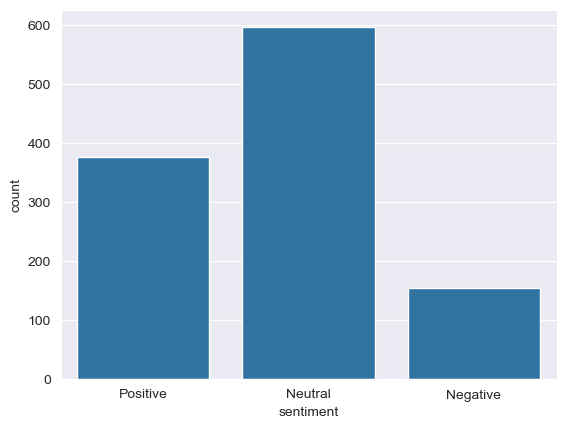

In [40]:
# plt.figure(figsize=(12,6))
sns.countplot(x='sentiment', data=train)
plt.show()

In [41]:
fig = go.Figure(go.Funnelarea(
    text=temp.sentiment,
    values=temp.text,
    title={"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
))
fig.show()

In [42]:
train['temp_list'] = train['text'].apply(lambda x: str(x).split())
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words', 'count']
temp.style.background_gradient(cmap='Blues')

In [43]:
def remove_stopword(x):
    return [y for y in x if y not in stopwords.words('english')]


train['temp_list'] = train['temp_list'].apply(remove_stopword)

In [44]:
def common_words(x):
    top = Counter([item for sublist in x['temp_list'] for item in sublist])
    temp = pd.DataFrame(top.most_common(20))
    temp.columns = ['Common_words', 'count']
    # temp.style.background_gradient(cmap='Greens')
    return temp

# Data Visualization

In [45]:
train_com_words = common_words(train)
train_com_words.style.background_gradient(cmap='Purples')

In [46]:
def bar_show(data, path='Common_words', title='Most Common'):
    figure = px.bar(data, x="count", y=path, title=f'{title} in Text', orientation='h',
                    width=700, height=700, color='Common_words')
    figure.show()

In [47]:
def treemap_show(data, path='Common_words', title='Most Common'):
    figure = px.treemap(data, path=[path], values='count', title=f'Tree of {title} Words')
    figure.show()

In [48]:
def donut(data, title='Unique Positive'):
    plt.figure(figsize=(16, 10))
    my_circle = plt.Circle((0, 0), 0.7, color='white')
    try:
        plt.pie(data['count'], labels=data.Common_words)  #, colors=Pastel1_7.hex_colors
    except:
        plt.pie(data['count'], labels=data.words)  #, colors=Pastel1_7.hex_colors
    p = plt.gcf()
    p.gca().add_artist(my_circle)
    plt.title(f'DoNut Plot Of {title} Words')
    plt.show()

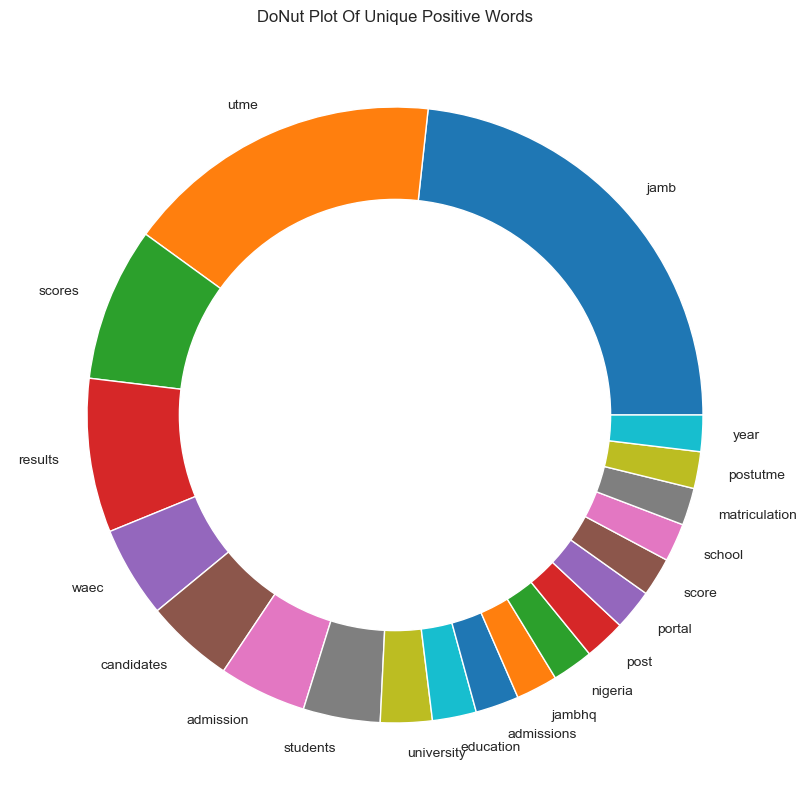

In [49]:
donut(train_com_words)

In [50]:
treemap_show(train_com_words)

In [51]:
bar_show(train_com_words)

In [52]:
Positive_sent = train[train['sentiment'] == 'Positive']
Negative_sent = train[train['sentiment'] == 'Negative']
Neutral_sent = train[train['sentiment'] == 'Neutral']

In [53]:
#Most common positive words
Positive_com_words = common_words(Positive_sent)
Positive_com_words.style.background_gradient(cmap='Blues')

In [54]:
bar_show(Positive_com_words)

In [55]:
treemap_show(Positive_com_words)

In [56]:
#Most common Negative words
Negative_com_words = common_words(Negative_sent)
Negative_com_words.style.background_gradient(cmap='Reds')

In [57]:
bar_show(Negative_com_words)

In [58]:
treemap_show(Negative_com_words)

In [59]:
#Most common neutral words
Neutral_com_words = common_words(Neutral_sent)
Neutral_com_words.style.background_gradient(cmap='Greens')

In [60]:
bar_show(Neutral_com_words)

In [61]:
treemap_show(Neutral_com_words)

In [62]:
raw_text = [word for word_list in train['temp_list'] for word in word_list]

In [63]:
def words_unique(sentiment, numwords, raw_words):
    """
    Input:
        segment - Segment category (ex. 'Neutral');
        numwords - how many specific words do you want to see in the final result; 
        raw_words - list  for item in train_data[train_data.segments == segments]['temp_list1']:
    Output: 
        dataframe giving information about the name of the specific ingredient and how many times it occurs in the chosen cuisine (in descending order based on their counts).

    """
    allother = []
    for item in train[train.sentiment != sentiment]['temp_list']:
        for word in item:
            allother.append(word)
    allother = list(set(allother))

    specificnonly = [x for x in raw_text if x not in allother]

    mycounter = Counter()

    for item in train[train.sentiment == sentiment]['temp_list']:
        for word in item:
            mycounter[word] += 1
    keep = list(specificnonly)

    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]

    Unique_words = pd.DataFrame(mycounter.most_common(numwords), columns=['words', 'count'])

    return Unique_words

In [64]:
Unique_Positive = words_unique('Positive', 20, raw_text)
print("The top 20 unique words in Positive Tweets are:")
Unique_Positive.style.background_gradient(cmap='Greens')

The top 20 unique words in Positive Tweets are:


In [65]:
treemap_show(Unique_Positive, path='words')

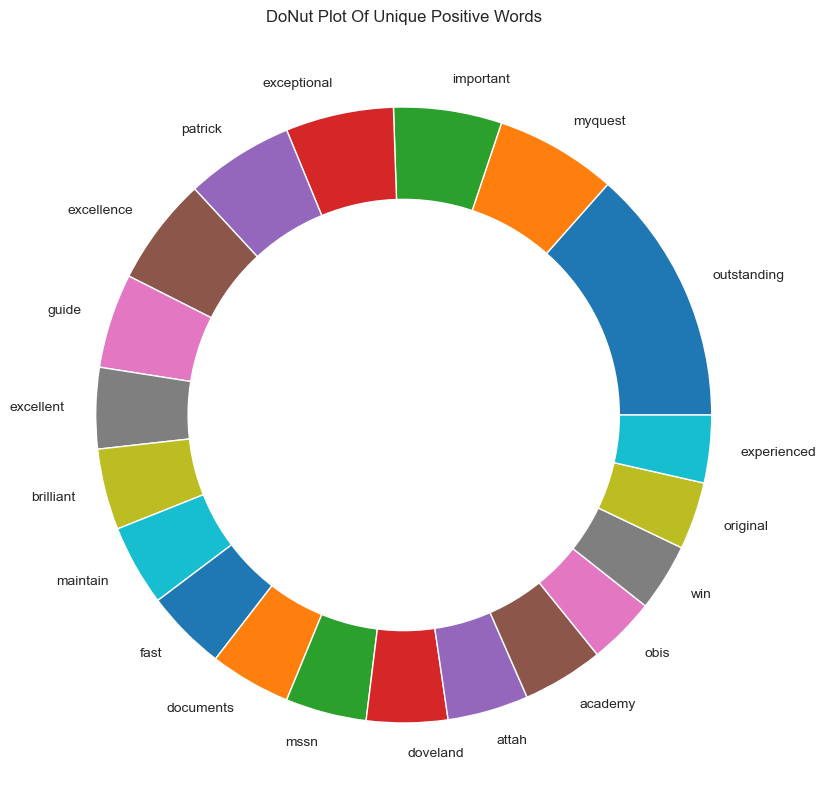

In [66]:
donut(Unique_Positive)

In [67]:
def generate_wordcloud(data, sentiment_filter=None):
    """Generate word cloud for tweets"""
    if sentiment_filter:
        text_data = data[data['sentiment'] == sentiment_filter]['text']
    else:
        text_data = data['text']

    # Combine all text
    all_text = ' '.join([clean_text(text) for text in text_data])

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400,
                          background_color='white',
                          colormap='viridis',
                          max_words=100).generate(all_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    title = f'Word Cloud - JAMB Tweets'
    if sentiment_filter:
        title += f' ({sentiment_filter} Sentiment)'
    plt.title(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

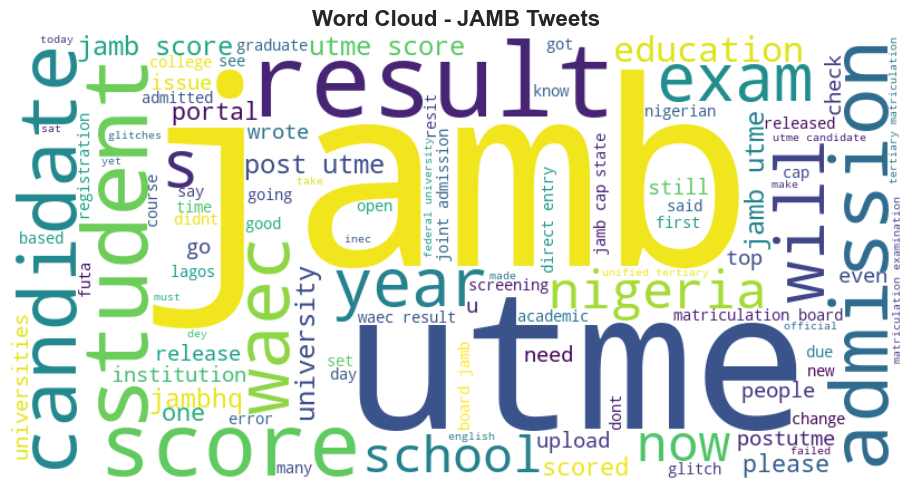

In [68]:
generate_wordcloud(train)

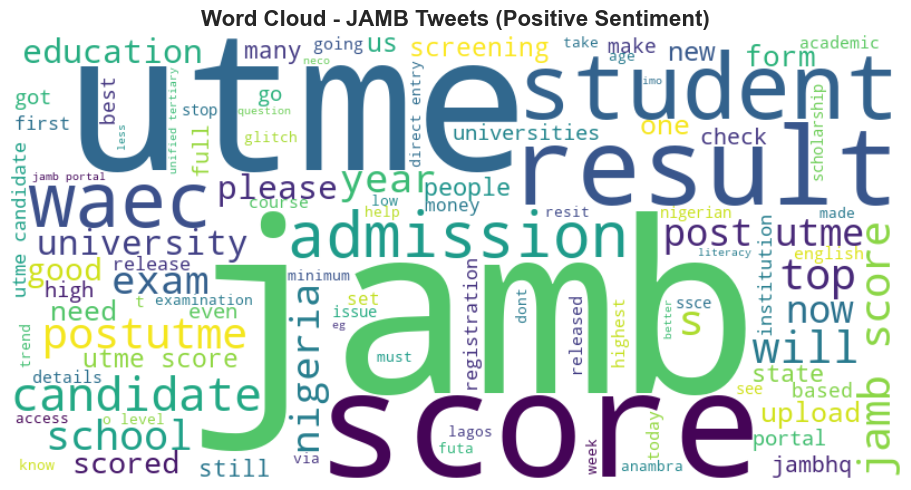

In [90]:
generate_wordcloud(train,sentiment_filter='Positive')

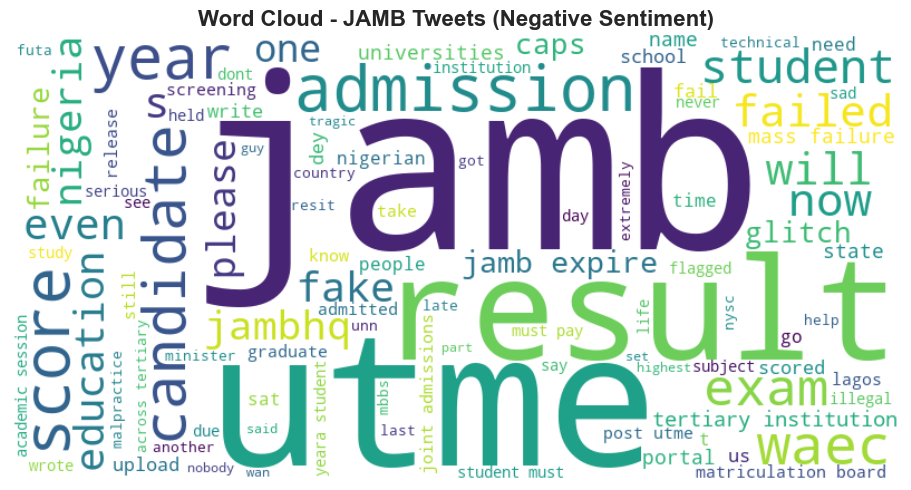

In [114]:
generate_wordcloud(train,sentiment_filter='Negative')

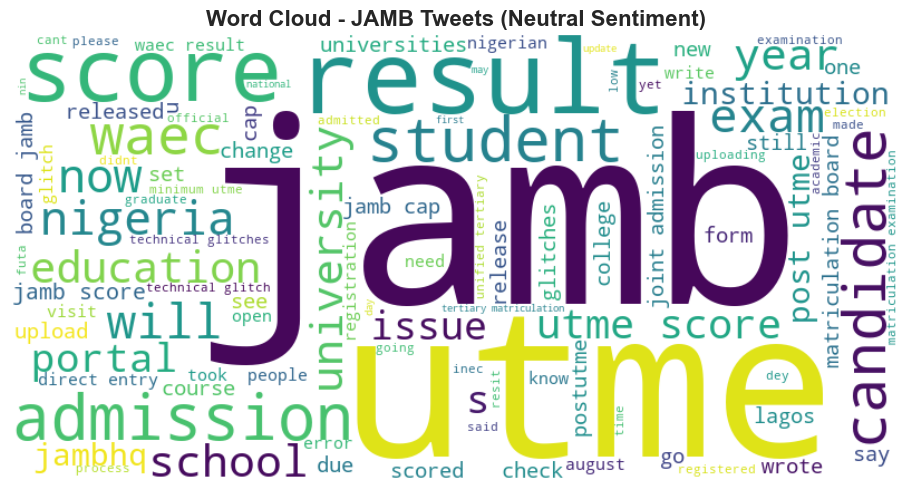

In [115]:
generate_wordcloud(train,sentiment_filter='Neutral')

## The End of EDA

## Model Training and evaluations 

In [96]:
df = train
df.head()

text         username  \
0  i think there should be a law that allows anyo...        Isaiah900   
1  unical cancels  postutme aptitude test –candid...  dauthoritymedia   
2  jambhq  even placed some candidates result und...       UdoAzuwike   
3  if not because of money and jambit suppose be ...       Sixtus6622   
4  i don’t think this is true jamb made it clear ...       zeezou_szn   

                  timestamp  likes  retweets sentiment  polarity  \
0  2025-08-14T18:49:45.000Z      0         0  Positive  0.220000   
1  2025-08-14T18:18:09.000Z      0         0   Neutral  0.000000   
2  2025-08-14T10:25:33.000Z     13         4  Negative -0.325000   
3  2025-08-14T08:17:27.000Z      0         0  Positive  0.333333   
4  2025-08-13T20:58:47.000Z      0         0  Positive  0.326786   

   subjectivity                                          temp_list  
0      0.260000  [think, law, allows, anyone, incredible, intel...  
1      0.000000  [unical, cancels, postutme, aptitude, test, –c...  
2      0.750000  [jambhq, even, placed, candidates, result, scr...  
3      0.566667  [money, jambit, suppose, advanced, technical, ...  
4      0.526190  [don’t, think, true, jamb, made, clear, kid, s...

In [97]:
X = df['text']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [104]:
def predictTweetText(text: str) -> str:
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    if polarity > 0:
        return "Positive"
    elif polarity < 0:
        return "Negative"
    else:
        return "Neutral"

In [105]:

# Predict on Test set
y_pred = [predictTweetText(text) for text in X_test]

In [106]:
# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7964601769911505

Classification Report:
               precision    recall  f1-score   support

    Negative       0.70      1.00      0.83        38
     Neutral       1.00      0.60      0.75       115
    Positive       0.71      1.00      0.83        73

    accuracy                           0.80       226
   macro avg       0.80      0.87      0.80       226
weighted avg       0.86      0.80      0.79       226




Confusion Matrix:
 [[38  0  0]
 [16 69 30]
 [ 0  0 73]]


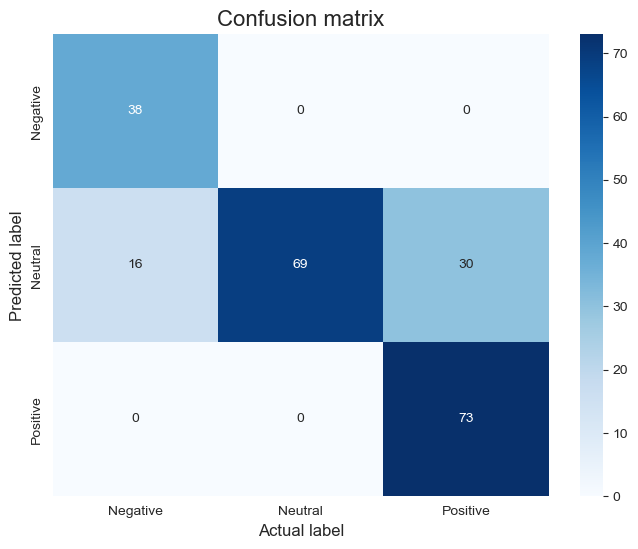

In [107]:
def plot_confusion_matrix():
    """Function to plot confusion matrix for the passed model and the data"""

    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    # use model to do the prediction
    # compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    # plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d',
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    plt.show()

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
plot_confusion_matrix()

In [112]:
predictTweetText('i like how jamb works, the result is like a mirror of your intelligence')

'Neutral'

In [113]:
predictTweetText("jamb is shit")

'Negative'

# The End